# <center>Predicting Toronto Traffic Flow
## <center>CS 4442 - Final Project
### <center>
### <center>Andrew Bliss, Abeer Muhammad

The following is the code which will take historic data at a given intersection and use it to predict traffic flow volumes at any given time:

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout
from tensorflow.keras.layers import Input

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Random Forest Implementation

In [3]:

# modify this if u need
#df = pd.read_csv('/content/drive/MyDrive/DS 3000/FinalProject/RawTrafficData.csv')
df = pd.read_csv('/content/drive/MyDrive/AI2/Final/tf-ft-eng.csv')

# Drop rows where traffic_source is not 'Toronto'
df = df[df['traffic_source'] == 'Toronto']

street1 = 'ADELAIDE'
street2 = 'PARLIAMENT'

# Function to process data for a given street or combination LOOK FOR USE CASE BELOW
def process_street_data(df, street_filter):
    filtered_df = df[df['camera_road'].str.contains(street_filter, case=False, na=False)]

    # Calculate the percentage of missing values in each row for date columns
    date_cols = [col for col in filtered_df.columns if col.startswith('x')]
    filtered_df['missing_percentage'] = filtered_df[date_cols].isnull().sum(axis=1) / len(date_cols)

    # Remove rows with 60% or more missing values in date columns
    filtered_df = filtered_df[filtered_df['missing_percentage'] < 0.6]

 # to remove outliers
    Q1 = filtered_df[date_cols].stack().quantile(0.25)  # 25th percentile
    Q3 = filtered_df[date_cols].stack().quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
    upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers

    # Remove both lower and upper outliers
    filtered_df = filtered_df[
        (filtered_df[date_cols] >= lower_bound).any(axis=1) &
        (filtered_df[date_cols] <= upper_bound).any(axis=1)
    ]

    # Drop the first 5 columns (metadata columns)
    filtered_df = filtered_df.drop(filtered_df.columns[:5], axis=1)

    # Calculate the sum of each date column
    date_sums = filtered_df[date_cols].sum(axis=0)

    # Create a new DataFrame with the date column sums
    traffic_data = pd.DataFrame({'Traffic day': date_cols, 'Traffic count': date_sums})

    # Impute missing values in the 'Traffic count' column in traffic_data
    imputer = SimpleImputer(strategy='mean')
    traffic_data['Traffic count'] = imputer.fit_transform(traffic_data[['Traffic count']])

    # Convert 'Traffic day' to datetime format
    traffic_data['Traffic day'] = pd.to_datetime(traffic_data['Traffic day'].str[1:], format='%Y_%m_%d')

    # Extract day of the week, numeric month, and day of the month
    traffic_data['day_of_week'] = traffic_data['Traffic day'].dt.dayofweek
    traffic_data['month'] = traffic_data['Traffic day'].dt.month
    traffic_data['day_of_month'] = traffic_data['Traffic day'].dt.day

    # Reorder the columns
    traffic_data = traffic_data[['Traffic day', 'day_of_week', 'month', 'day_of_month', 'Traffic count']]

    # Drop rows where 'Traffic count' equals 0
    traffic_data = traffic_data[traffic_data['Traffic count'] != 0]

    # Set 'Traffic day' as the index
    traffic_data.set_index('Traffic day', inplace=True)

    return traffic_data



# Process data for street1
'''

single street call

'''
street1_data = process_street_data(df, street1)

# Process data for street1
street2_data = process_street_data(df, street2)

# Process data for street1 and street2 intersection
'''
SYNTAX for intersection:

.* : Matches any number of characters (including none) between street1 and street2
|  : An OR condition, meaning it will match either street1 followed by street2 or street2 followed by street1

'''
intersection_data = process_street_data(df, f"{street1}.*{street2}|{street2}.*{street1}")

# Display results
print(street1+" Data")
print(street1_data.head())

print("\n"+street2+" Data")
print(street2_data.head())

print("\nIntersection Data")
print(intersection_data.head())

# Outputs are stored in street1_data, street2_data, and intersection_data DataFrames.

ADELAIDE Data
             day_of_week  month  day_of_month  Traffic count
Traffic day                                                 
2022-02-03             3      2             3          538.0
2022-02-04             4      2             4          867.0
2022-02-05             5      2             5          565.0
2022-02-06             6      2             6          556.0
2022-02-07             0      2             7          745.0

PARLIAMENT Data
             day_of_week  month  day_of_month  Traffic count
Traffic day                                                 
2022-02-03             3      2             3          884.0
2022-02-04             4      2             4         1578.0
2022-02-05             5      2             5          856.0
2022-02-06             6      2             6          956.0
2022-02-07             0      2             7         1435.0

Intersection Data
             day_of_week  month  day_of_month  Traffic count
Traffic day                        

<ipython-input-3-a85e3103f7d4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['missing_percentage'] = filtered_df[date_cols].isnull().sum(axis=1) / len(date_cols)
<ipython-input-3-a85e3103f7d4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['missing_percentage'] = filtered_df[date_cols].isnull().sum(axis=1) / len(date_cols)
<ipython-input-3-a85e3103f7d4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [4]:
def visualize_traffic_data(street1_data, street2_data, intersection_data):

    plt.figure(figsize=(18, 25))

    # Time-series plot for all three datasets
    plt.subplot(4, 1, 1)
    plt.plot(street1_data.index, street1_data['Traffic count'], label=street1, color='blue')
    plt.plot(street2_data.index, street2_data['Traffic count'], label=street2, color='green')
    plt.plot(intersection_data.index, intersection_data['Traffic count'], label='Intersection', color='red')
    plt.title('Traffic Count Over Time')
    plt.xlabel('Date')
    plt.ylabel('Traffic Count')
    plt.legend()

    # Box plot for street1
    plt.subplot(4, 1, 2)
    sns.boxplot(data=street1_data, x='day_of_week', y='Traffic count', palette='Blues')
    plt.title('Traffic Count by Day of Week - '+street1)
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Traffic Count')

    # Box plot for Parliament
    plt.subplot(4, 1, 3)
    sns.boxplot(data=street2_data, x='day_of_week', y='Traffic count', palette='Greens')
    plt.title('Traffic Count by Day of Week - '+street2)
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Traffic Count')

    # Box plot for Intersection
    plt.subplot(4, 1, 4)
    sns.boxplot(data=intersection_data, x='day_of_week', y='Traffic count', palette='Reds')
    plt.title('Traffic Count by Day of Week - Intersection')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Traffic Count')

    plt.tight_layout()
    plt.show()

    # Pie chart for traffic distribution (separate figure)
    plt.figure(figsize=(8, 8))
    total_street1 = street1_data['Traffic count'].sum()
    total_street2 = street2_data['Traffic count'].sum()
    #total_intersection = intersection_data['Traffic count'].sum()
    ratios = [total_street1, total_street2]
    labels = [street1, street2, ]
    plt.pie(ratios, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title('Traffic Distribution Across Datasets')
    plt.show()

In [5]:
def prepare_ml_features(data, lag_features=3):
    """
    Prepares features for machine learning, including lag features and temporal attributes.
        data : Data containing 'Traffic count' and temporal features.
        lag_features : Number of lag features to create.|

    Returns:
        X : Feature matrix.
        y : Target variable (Traffic count).
    """
    # Create lag features
    for i in range(1, lag_features + 1):
        data[f'traffic_lag_{i}'] = data['Traffic count'].shift(i)


    # Drop rows with NaN values (introduced by lag features)
    ml_data = data.dropna()

    # Prepare feature list
    features = [f'traffic_lag_{i}' for i in range(1, lag_features + 1)] + \
               ['day_of_week', 'month', 'day_of_month']

    # Extract features and target
    X = ml_data[features]
    y = ml_data['Traffic count']

    return X, y

In [6]:
def train_and_evaluate_rf_model(X, y, test_size=0.3, n_estimators=100, random_state=42):
    """
    Trains and evaluates a Random Forest Regressor model on traffic data.
        X : Feature set.
        y : Target variable (Traffic count).
        test_size : Proportion of data to use for testing (default 0.3).
        n_estimators : Number of estimators for the Random Forest (default 100).
        random_state : Random state for reproducibility (default 42).

    Returns:
         Evaluation metrics (MAE, RMSE, R²).
         Trained model.
         Scaler used for the features.
         Scaled training and testing sets (X_train_scaled, X_test_scaled, y_train, y_test).
    """
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    # Scaling the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train_scaled, y_train)

    # Making predictions using the model
    y_pred = rf_model.predict(X_test_scaled)

    # Defining model evaluation metrics
    rf_metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

    # Plotting actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linewidth=2)
    plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--', color='orange', linewidth=2)
    plt.title('Actual vs Predicted Traffic Count')
    plt.xlabel('Date')
    plt.ylabel('Traffic Count')
    plt.legend()
    plt.grid(True)
    plt.show()

    return rf_metrics, rf_model, scaler, (X_train_scaled, X_test_scaled, y_train, y_test)

In [7]:
def predict_future_periods(model, scaler, X, periods=5):
    """
    Predicts future traffic counts based on the model

    Parameters:
        model: Trained machine learning model.
        scaler: Scaler used to normalize the feature set.
        X : Feature set used for predictions.
        periods: Number of future periods to predict.

    Returns:
      Predicted traffic counts for the specified number of future periods.
    """
    # Prepare the last known data for predictions
    last_data = X.iloc[-1:].copy()

    # Convert to float to accommodate predictions
    last_data = last_data.astype(float)

    predictions = []
    for _ in range(periods):
        # Scale the input features
        last_data_scaled = scaler.transform(last_data)

        # Predict the next period
        prediction = model.predict(last_data_scaled)[0]
        predictions.append(prediction)

        # Update the lag features
        last_data.iloc[0, :-1] = last_data.iloc[0, 1:]  # Shift lag features
        last_data.iloc[0, -1] = prediction  # Update the last lag with the new prediction


        # Validate feature count
        if last_data.shape[1] < 3:
            raise ValueError("Insufficient columns in last_data for lag feature update.")

    # Generate a date range for the predictions
    future_dates = pd.date_range(start=X.index[-1] + pd.Timedelta(days=1), periods=periods)

    return pd.Series(predictions, index=future_dates)

In [8]:
# Predict future periods for all datasets
def predict_future_periods_for_all(models, scalers, datasets, periods=7):
    """
    Predicts future traffic counts for multiple datasets using corresponding models and scalers.

        models: Dictionary containing trained models for each dataset (keys: 'street1', 'street2', 'Intersection').
        scalers: Dictionary containing scalers used to normalize the feature sets for each dataset.
        datasets: Dictionary containing feature sets for each dataset (keys are dataset names, values are feature sets).
        periods: Number of future periods to predict.

    Returns:
        dict: Predicted traffic counts for each dataset as a dictionary of pd.Series.
    """
    predictions_all = {}

    for dataset_name, X in datasets.items():
        model = models[dataset_name]
        scaler = scalers[dataset_name]

        # Use predict_future_periods to get predictions for each dataset
        predictions = predict_future_periods(
            model=model,
            scaler=scaler,
            X=X,
            periods=periods,
        )
        predictions_all[dataset_name] = predictions

    return predictions_all


<ipython-input-4-42f8acc65482>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=street1_data, x='day_of_week', y='Traffic count', palette='Blues')
<ipython-input-4-42f8acc65482>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=street2_data, x='day_of_week', y='Traffic count', palette='Greens')
<ipython-input-4-42f8acc65482>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=intersection_data, x='day_of_week', y='Traffic count', palette='Reds')


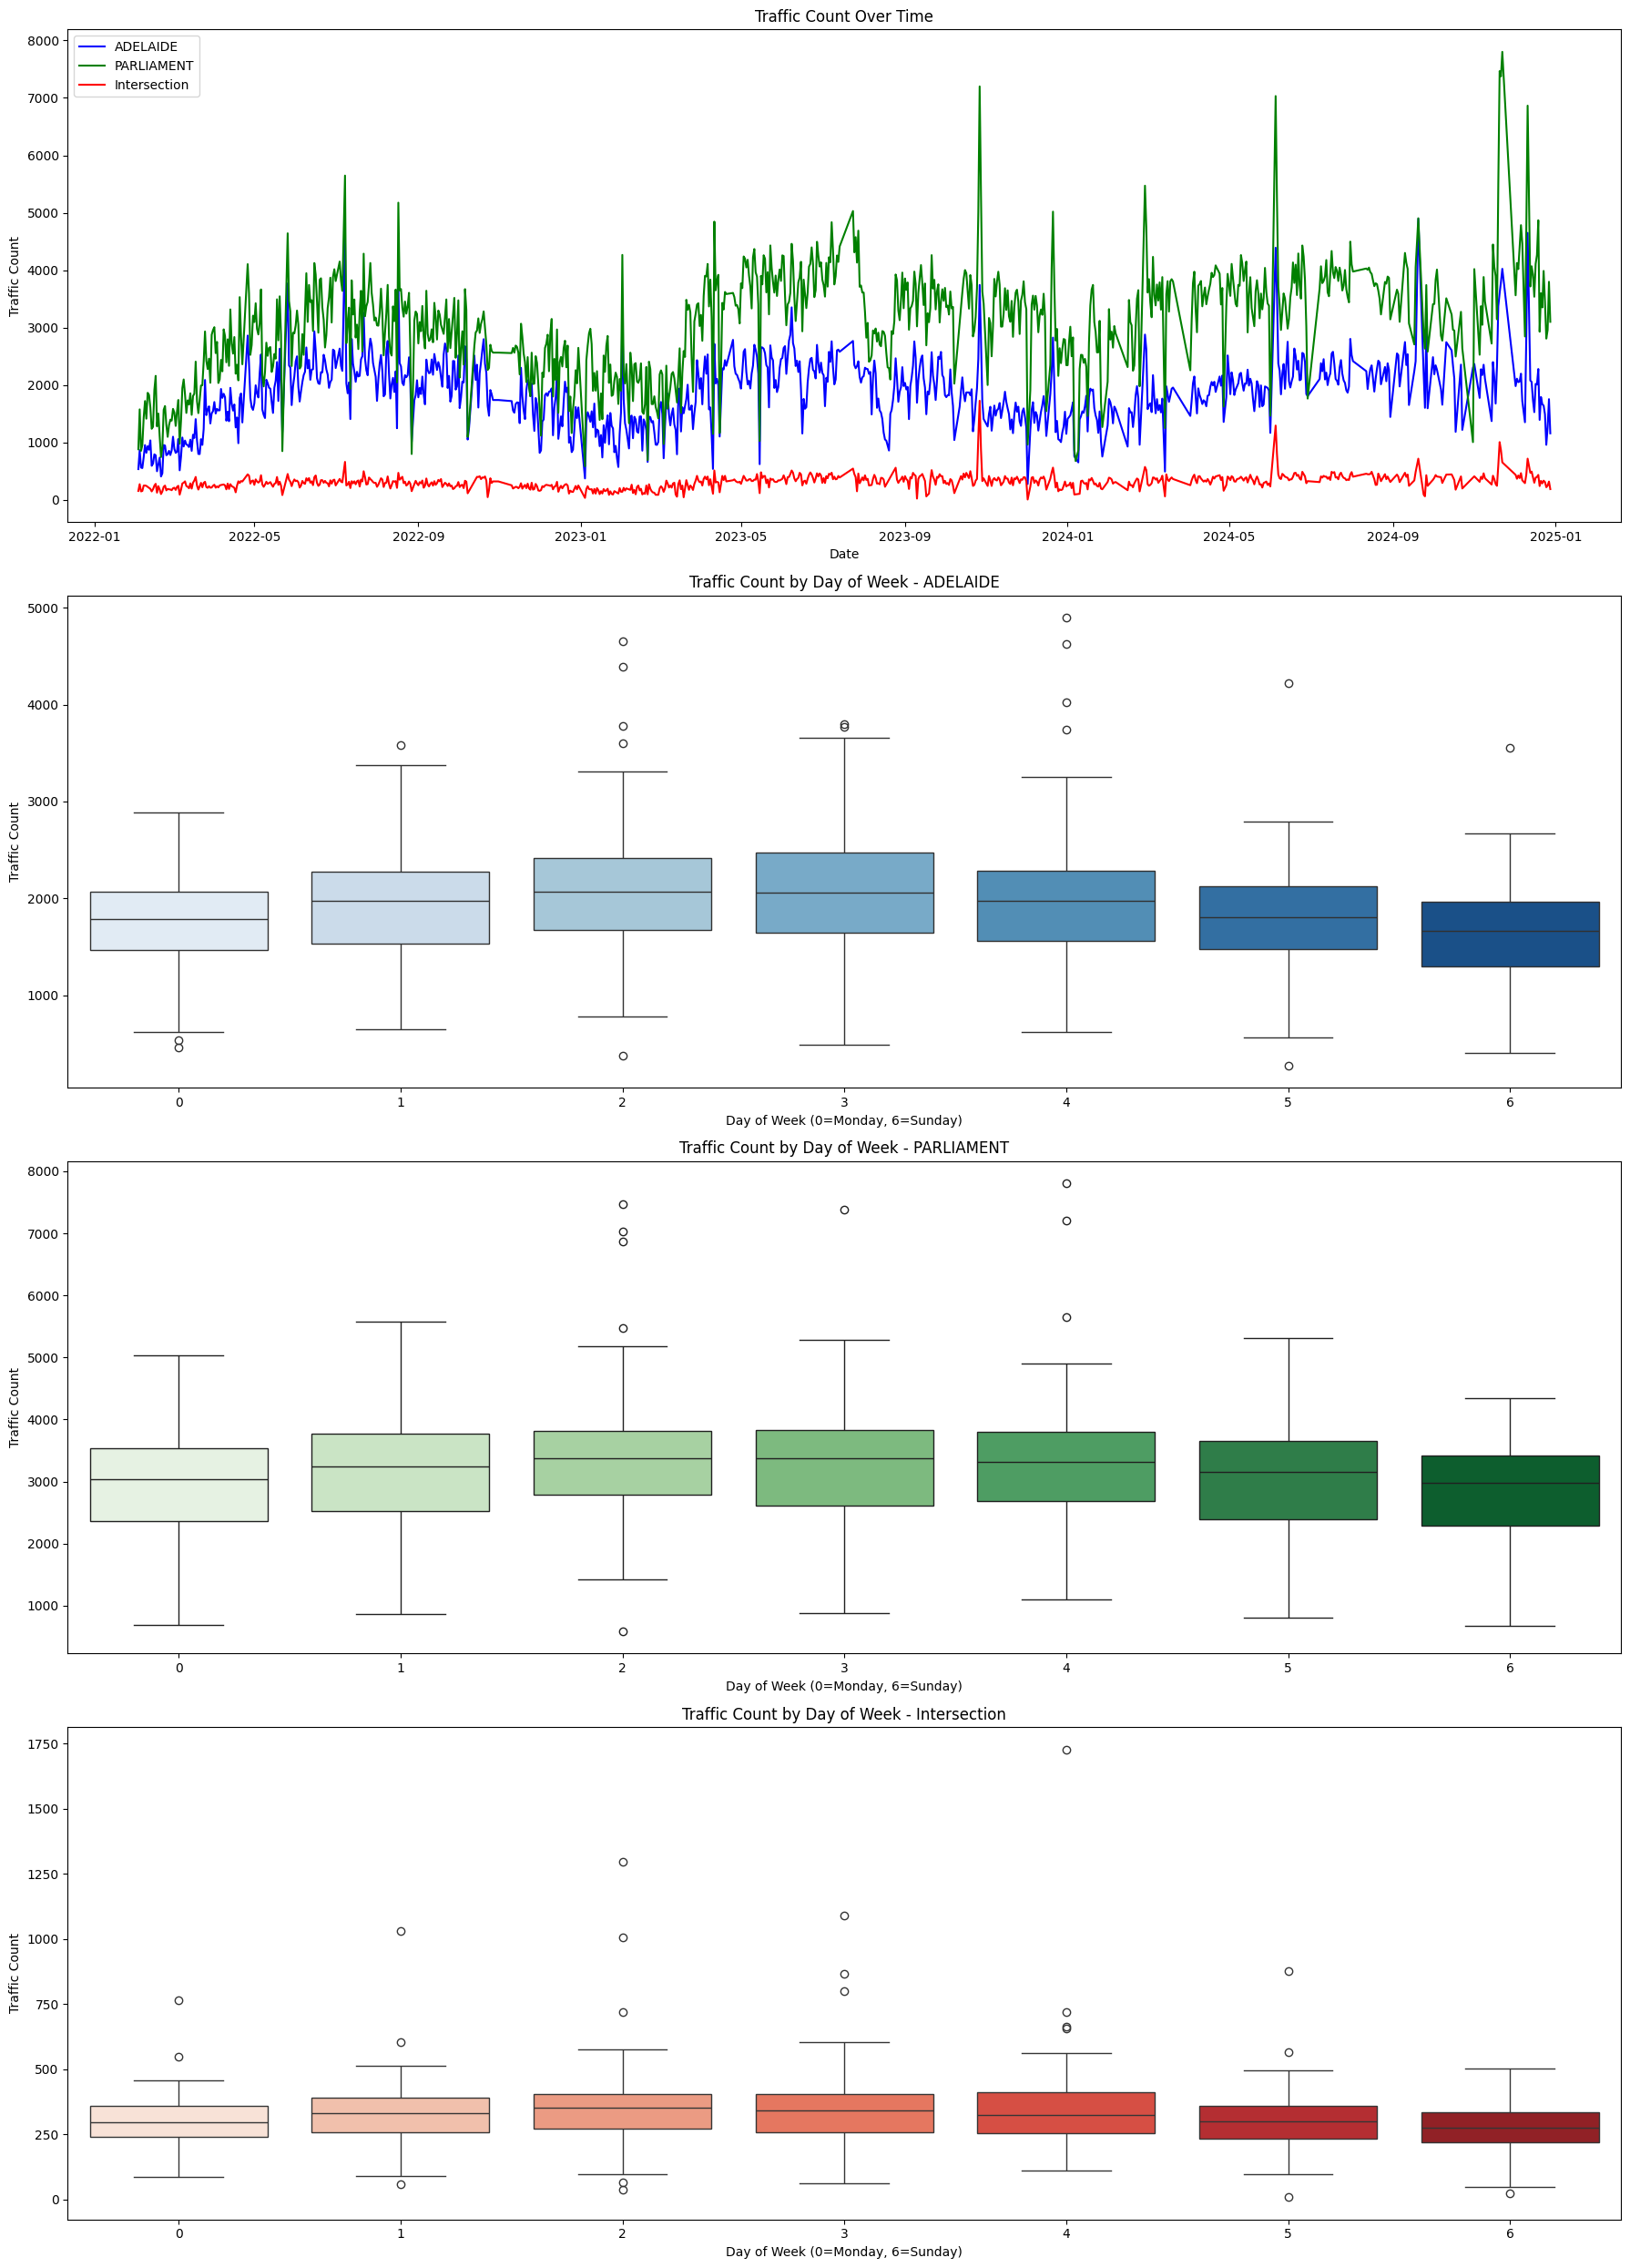

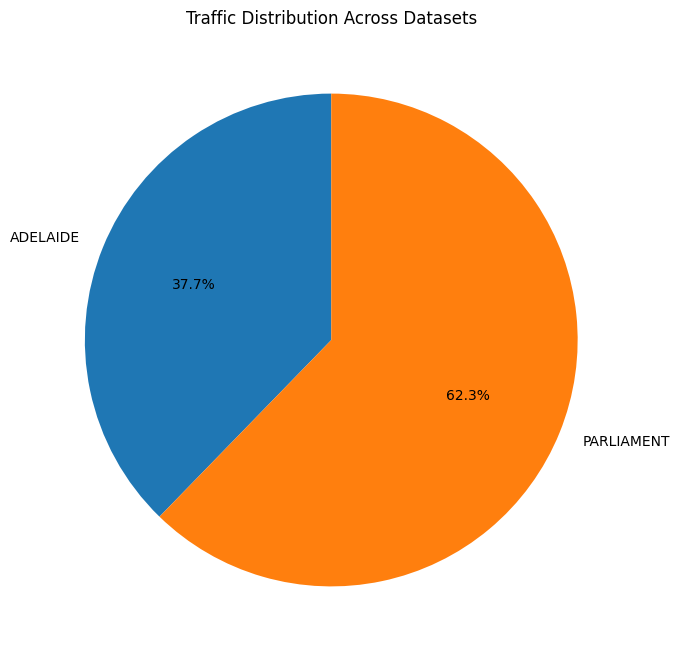

In [9]:
#visualizing the data
visualize_traffic_data(street1_data, street2_data, intersection_data)

Training model for ADELAIDE...


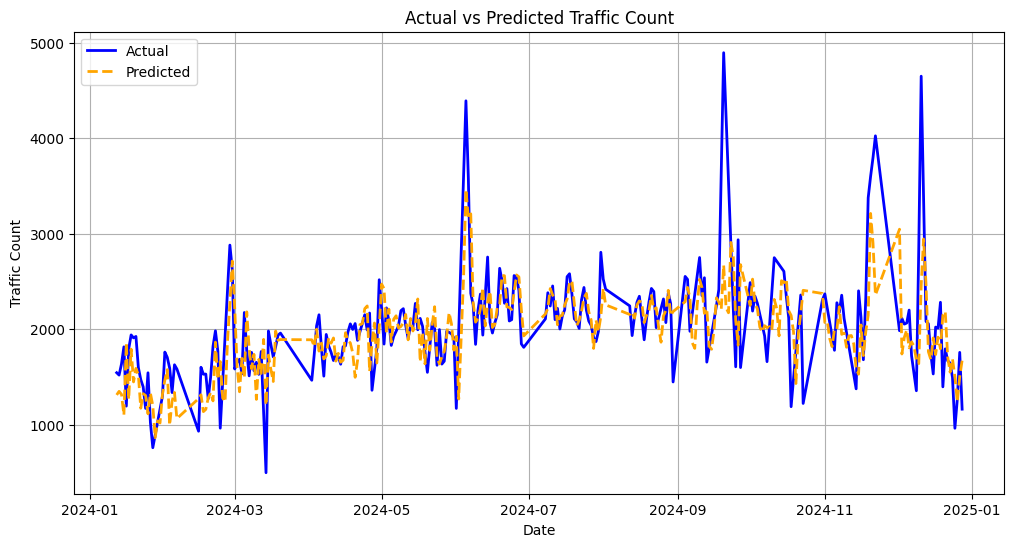

Evaluation Metrics for ADELAIDE: {'MAE': 301.59599315068493, 'RMSE': 448.9410676433833, 'R2': 0.395038675909693}
Training model for PARLIAMENT...


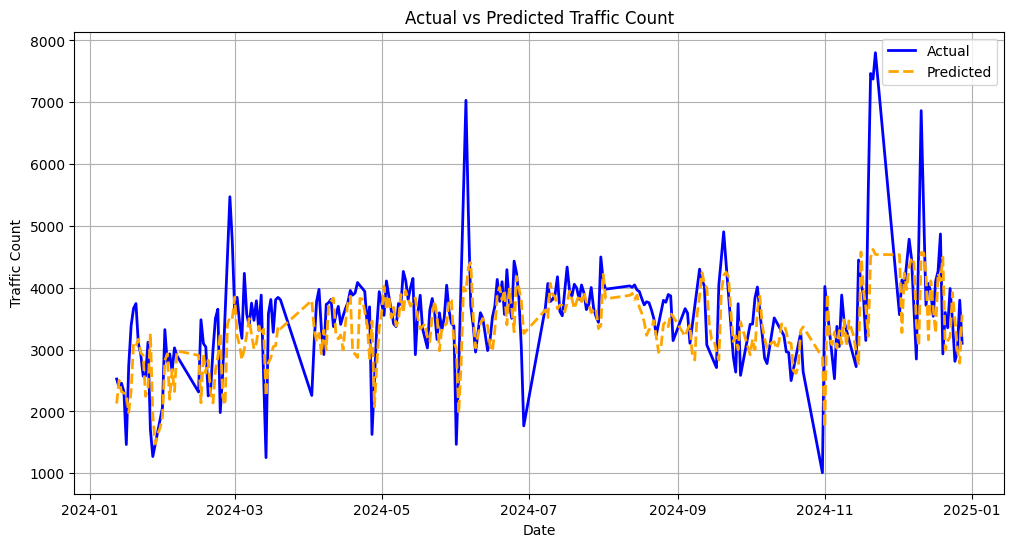

Evaluation Metrics for PARLIAMENT: {'MAE': 504.0218493150685, 'RMSE': 726.7026989135372, 'R2': 0.2791077804462301}
Training model for Intersection...


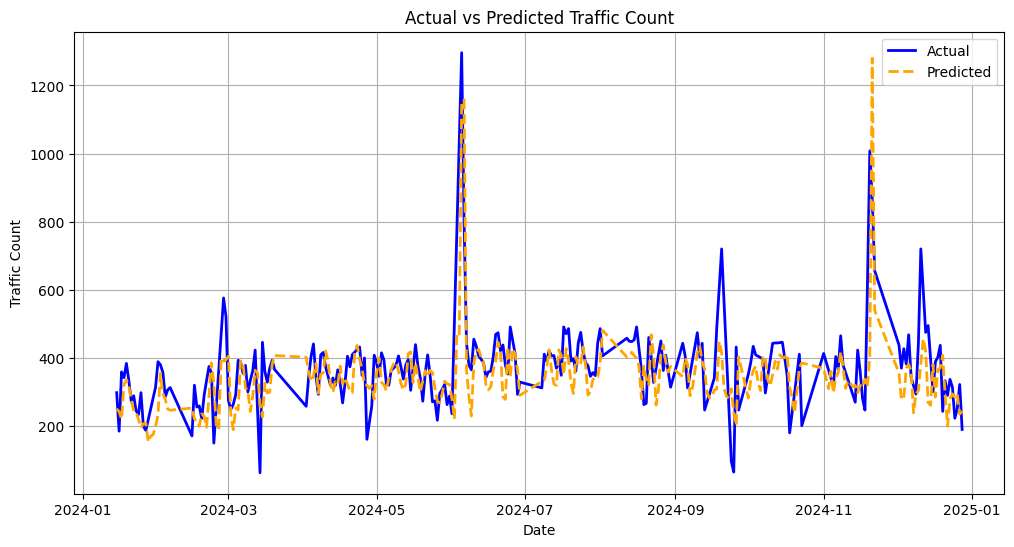

Evaluation Metrics for Intersection: {'MAE': 74.62631944444443, 'RMSE': 106.73860114785091, 'R2': 0.2915340231183179}

Future Predictions for ADELAIDE:
2024-12-29    1673.09
2024-12-30    1786.85
2024-12-31     876.06
2025-01-01     873.00
2025-01-02    1292.81
2025-01-03    1778.18
2025-01-04    1295.04
Freq: D, dtype: float64


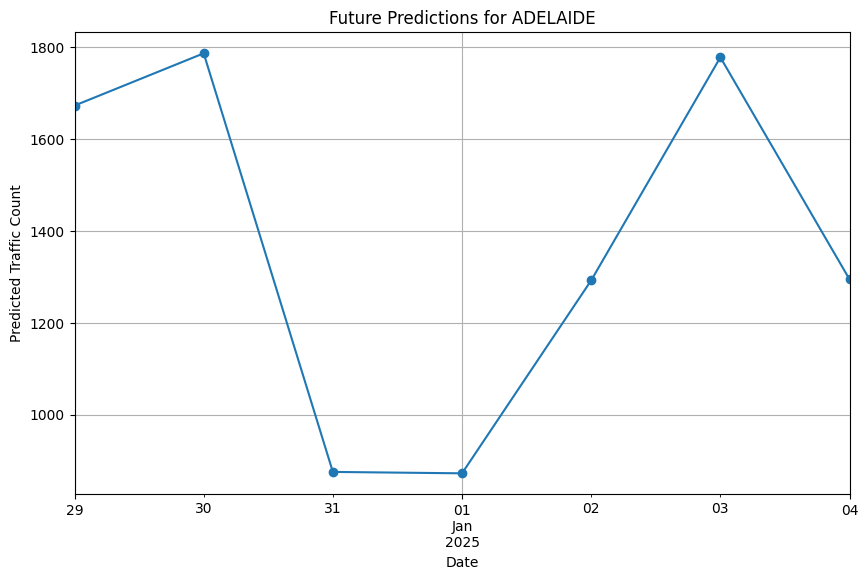


Future Predictions for PARLIAMENT:
2024-12-29    3566.25
2024-12-30    2373.01
2024-12-31    2718.28
2025-01-01    1654.42
2025-01-02    1720.03
2025-01-03    1878.44
2025-01-04    3119.78
Freq: D, dtype: float64


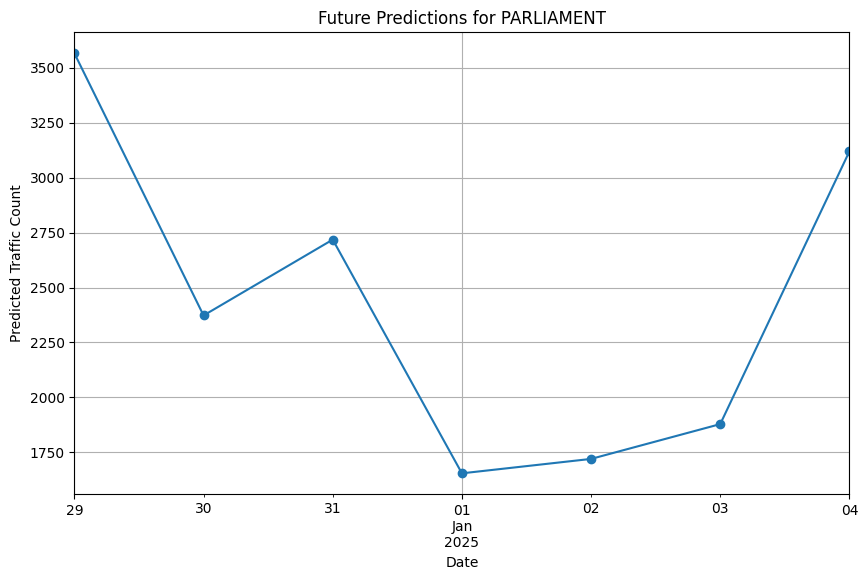


Future Predictions for Intersection:
2024-12-29    243.65
2024-12-30    261.00
2024-12-31    274.83
2025-01-01    230.45
2025-01-02    191.55
2025-01-03    185.87
2025-01-04    212.03
Freq: D, dtype: float64


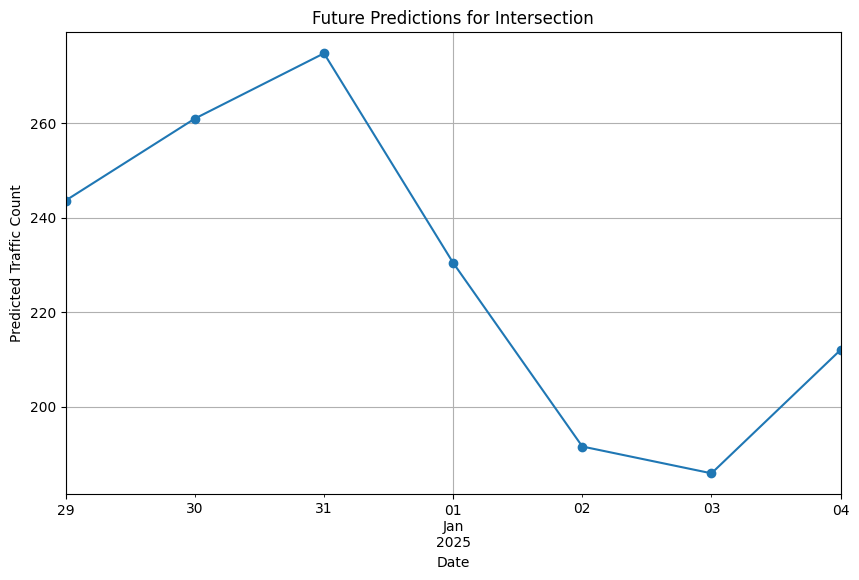

In [10]:
# Prepare features and target variables for each dataset
datasets = {
    street1: street1_data,
    street2: street2_data,
    'Intersection': intersection_data
}

prepared_data = {}
for name, data in datasets.items():
    X, y = prepare_ml_features(data, lag_features=3)
    prepared_data[name] = (X, y)

# Train and evaluate models for each dataset
models = {}
scalers = {}
results = {}
scaled_data = {}

for name, (X, y) in prepared_data.items():
    print(f"Training model for {name}...")
    metrics, model, scaler, scaled_sets = train_and_evaluate_rf_model(X, y)
    models[name] = model
    scalers[name] = scaler
    results[name] = metrics
    scaled_data[name] = scaled_sets  # Stores scaled train/test data
    print(f"Evaluation Metrics for {name}: {metrics}")

# Call the prediction function
future_predictions = predict_future_periods_for_all(
    models=models,
    scalers=scalers,
    datasets={name: data[0] for name, data in prepared_data.items()},  # Pass feature sets
    periods=7  # Predict for the next 7 days
)

# Visualize future predictions
for dataset_name, predictions in future_predictions.items():
    print(f"\nFuture Predictions for {dataset_name}:")
    print(predictions)

    # Plot future predictions
    predictions.plot(figsize=(10, 6), marker='o', title=f'Future Predictions for {dataset_name}')
    plt.xlabel('Date')
    plt.ylabel('Predicted Traffic Count')
    plt.grid(True)
    plt.show()

## Convolutional Neural Network Implementation

In [11]:
#preparing the data for CNN
def prepare_cnn_data(X, y):
    #CNN needs a 3D input: (samples, time steps, features)
    X_reshaped = X.values.reshape(X.shape[0], X.shape[1], 1)
    return X_reshaped, y

In [12]:
#preprocessing the data for cnn by splitting it into the 80/20 test split and scaling it
def preprocess_data_for_cnn(X, y):

    #splitting training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    #scaling the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #reshaping the data for CNN
    X_train_cnn, y_train_cnn = prepare_cnn_data(pd.DataFrame(X_train_scaled), y_train)
    X_test_cnn, y_test_cnn = prepare_cnn_data(pd.DataFrame(X_test_scaled), y_test)

    return X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn, scaler

In [13]:
#building the CNN model
def build_cnn_model(input_shape):

    model = Sequential([
        Input(shape=input_shape),  # Explicit input layer
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)  # Single output for regression
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [14]:
# Train and Evaluate CNN Model (Simplified)
def train_and_evaluate_cnn_model(X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn, input_shape, epochs=30, batch_size=16):
    """
    Trains and evaluates a CNN model using preprocessed and reshaped data.

    Parameters:
    X_train_cnn : Training features (3D input for CNN)
    y_train_cnn : Training target
    X_test_cnn : Testing features (3D input for CNN)
    y_test_cnn : Testing target
    input_shape : Shape of the input data for the CNN
    epochs : Number of training epochs (default 30)
    batch_size : Batch size for training (default 16)

    Returns:
    Evaluation metrics (MAE, RMSE, R²)
    Trained CNN model
    """
    # Build the CNN model
    cnn_model = build_cnn_model(input_shape)

    # Train the CNN model
    cnn_model.fit(
        X_train_cnn, y_train_cnn,
        validation_data=(X_test_cnn, y_test_cnn),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
    )

    # Make predictions using the model
    y_pred = cnn_model.predict(X_test_cnn).flatten()

    # Define model evaluation metrics
    cnn_metrics = {
        'MAE': mean_absolute_error(y_test_cnn, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_cnn, y_pred)),
        'R2': r2_score(y_test_cnn, y_pred)
    }

    return cnn_metrics, cnn_model


In [15]:
def predict_future_periods_for_all(models, scalers, datasets, periods=7):
    """
    Generate future predictions for all datasets using trained models.

    Parameters:
    models : Trained models for each dataset.
    scalers : Scalers used to scale each dataset.
    datasetst: Feature datasets to predict future periods.
    periods : Number of future periods to predict.

    Returns:
    Future predictions for each dataset.
    """
    future_predictions = {}
    for name, model in models.items():
        print(f"Generating future predictions for {name}...")

        # Retrieve the dataset and scaler
        X_data = datasets[name]
        scaler = scalers[name]

        # Scale the input data
        X_scaled = scaler.transform(X_data)

        # Reshape the data for the CNN model
        X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

        # Generate predictions
        predictions = []
        for _ in range(periods):
            # Predict the next period
            pred = model.predict(X_cnn[-1].reshape(1, X_cnn.shape[1], X_cnn.shape[2]))
            predictions.append(pred.flatten()[0])

            # Update the input data with the new prediction
            new_input = np.append(X_cnn[-1][1:], [[pred.flatten()[0]]], axis=0)
            X_cnn = np.append(X_cnn, [new_input], axis=0)

        # Prepare data for inverse transformation
        dummy_data = np.zeros((len(predictions), X_scaled.shape[1]))
        dummy_data[:, -1] = predictions  # Place predictions in the last column

        # Inverse transform predictions to original scale
        predictions = scaler.inverse_transform(dummy_data)[:, -1]
        future_predictions[name] = pd.Series(predictions, name=f"{name} Predictions")

    return future_predictions

In [16]:
# Prepare features and target variables for each dataset
datasets = {
    street1: street1_data,
    street2: street2_data,
    'Intersection': intersection_data
}

prepared_data = {}
for name, data in datasets.items():
    X, y = prepare_ml_features(data, lag_features=3)
    prepared_data[name] = (X, y)

Training CNN model for ADELAIDE...
Epoch 1/30
49/49 - 3s - 52ms/step - loss: 3509315.2500 - mae: 1785.6366 - val_loss: 5016767.0000 - val_mae: 2162.3643
Epoch 2/30
49/49 - 0s - 6ms/step - loss: 2581045.2500 - mae: 1483.6652 - val_loss: 1911613.5000 - val_mae: 1250.4326
Epoch 3/30
49/49 - 0s - 6ms/step - loss: 426620.8438 - mae: 511.6060 - val_loss: 412452.9688 - val_mae: 464.5771
Epoch 4/30
49/49 - 0s - 6ms/step - loss: 298491.9688 - mae: 430.9962 - val_loss: 442673.1875 - val_mae: 479.6734
Epoch 5/30
49/49 - 0s - 6ms/step - loss: 291858.4688 - mae: 420.0925 - val_loss: 448856.0938 - val_mae: 483.1718
Epoch 6/30
49/49 - 0s - 6ms/step - loss: 292754.6250 - mae: 425.1901 - val_loss: 405171.0000 - val_mae: 456.7908
Epoch 7/30
49/49 - 0s - 6ms/step - loss: 290961.0000 - mae: 426.1062 - val_loss: 432537.0000 - val_mae: 471.3808
Epoch 8/30
49/49 - 0s - 4ms/step - loss: 286729.0625 - mae: 421.7469 - val_loss: 428150.9688 - val_mae: 468.1052
Epoch 9/30
49/49 - 0s - 4ms/step - loss: 282998.6562

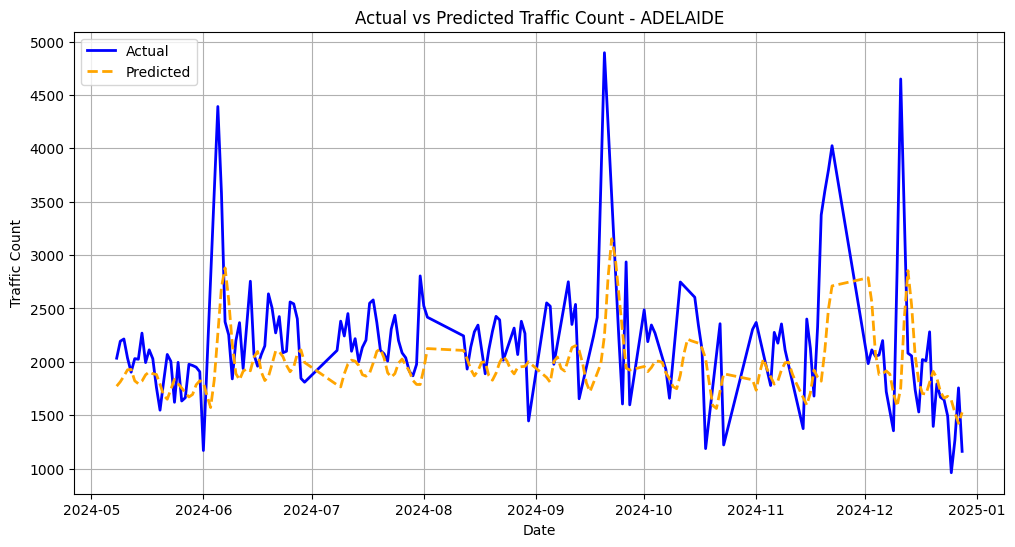

Evaluation Metrics for ADELAIDE: {'MAE': 417.0726981921074, 'RMSE': 593.9344183306125, 'R2': -0.03403637692959749}
Training CNN model for PARLIAMENT...
Epoch 1/30
49/49 - 3s - 57ms/step - loss: 9432936.0000 - mae: 2943.7737 - val_loss: 14137008.0000 - val_mae: 3663.1458
Epoch 2/30
49/49 - 0s - 5ms/step - loss: 8026291.5000 - mae: 2690.2283 - val_loss: 8859175.0000 - val_mae: 2853.9504
Epoch 3/30
49/49 - 0s - 6ms/step - loss: 2207082.0000 - mae: 1236.3958 - val_loss: 874300.5625 - val_mae: 660.5834
Epoch 4/30
49/49 - 0s - 5ms/step - loss: 697938.5000 - mae: 652.7361 - val_loss: 951094.5625 - val_mae: 689.6185
Epoch 5/30
49/49 - 0s - 4ms/step - loss: 679483.8750 - mae: 646.8712 - val_loss: 1004663.8750 - val_mae: 710.3058
Epoch 6/30
49/49 - 0s - 6ms/step - loss: 685591.3750 - mae: 647.0765 - val_loss: 959763.6250 - val_mae: 691.3949
Epoch 7/30
49/49 - 0s - 7ms/step - loss: 671799.0000 - mae: 642.9157 - val_loss: 954923.3125 - val_mae: 688.7487
Epoch 8/30
49/49 - 0s - 6ms/step - loss: 672

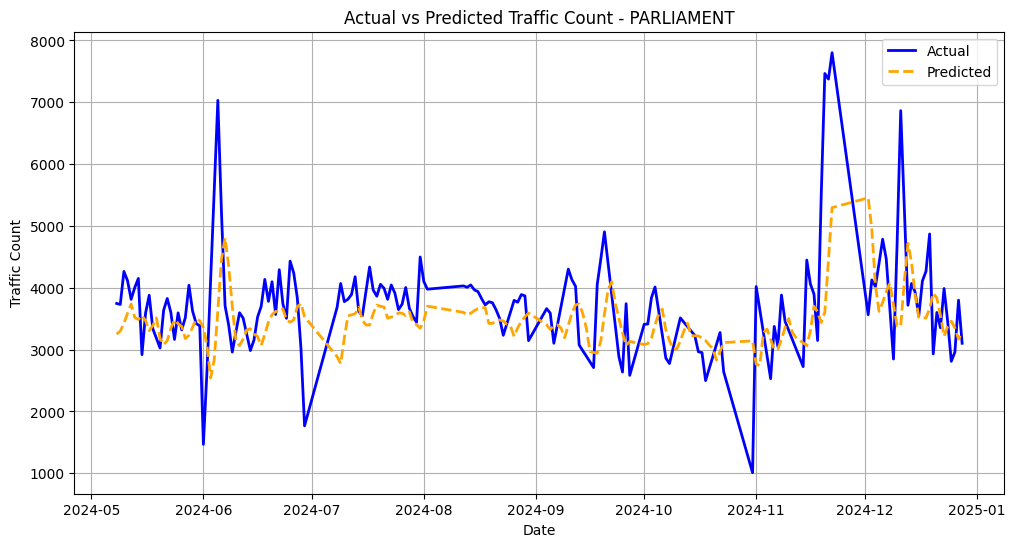

Evaluation Metrics for PARLIAMENT: {'MAE': 568.0472468449519, 'RMSE': 839.7851075280395, 'R2': 0.019193866408515614}
Training CNN model for Intersection...
Epoch 1/30
48/48 - 3s - 56ms/step - loss: 98199.2734 - mae: 291.7799 - val_loss: 151222.4375 - val_mae: 363.1385
Epoch 2/30
48/48 - 0s - 8ms/step - loss: 37279.2656 - mae: 151.6556 - val_loss: 22175.2109 - val_mae: 94.9021
Epoch 3/30
48/48 - 1s - 13ms/step - loss: 14029.7422 - mae: 85.3859 - val_loss: 29622.5078 - val_mae: 117.0139
Epoch 4/30
48/48 - 1s - 14ms/step - loss: 13544.3223 - mae: 83.7603 - val_loss: 28412.5098 - val_mae: 113.2599
Epoch 5/30
48/48 - 0s - 10ms/step - loss: 13302.6729 - mae: 82.3314 - val_loss: 25274.2031 - val_mae: 102.7879
Epoch 6/30
48/48 - 0s - 6ms/step - loss: 13356.4385 - mae: 82.5664 - val_loss: 26876.7520 - val_mae: 108.3017
Epoch 7/30
48/48 - 0s - 6ms/step - loss: 13013.2520 - mae: 80.8986 - val_loss: 27405.6113 - val_mae: 110.2645
Epoch 8/30
48/48 - 0s - 4ms/step - loss: 12863.1660 - mae: 80.6193 -

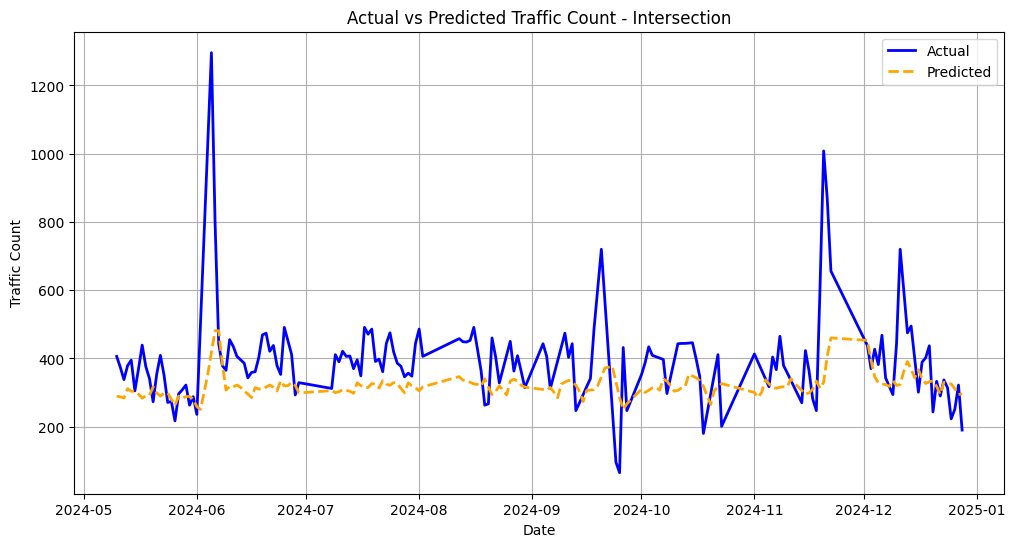

Evaluation Metrics for Intersection: {'MAE': 100.48866144816081, 'RMSE': 150.4226077282031, 'R2': -0.1714328680669166}


In [17]:
# Train and evaluate CNN models for each dataset
cnn_models = {}
cnn_scalers = {}
cnn_results = {}
cnn_scaled_data = {}

for name, (X, y) in prepared_data.items():
    print(f"Training CNN model for {name}...")

    # Preprocess data
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn, scaler = preprocess_data_for_cnn(X, y)

    # Define input shape for CNN
    input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])

    # Build, train, and evaluate the CNN model
    metrics, model = train_and_evaluate_cnn_model(
        X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn, input_shape
    )

    # Store results
    cnn_models[name] = model
    cnn_scalers[name] = scaler
    cnn_results[name] = metrics
    cnn_scaled_data[name] = (X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn)

    # Plot actual vs predicted
    y_pred = model.predict(X_test_cnn).flatten()
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_cnn.index, y_test_cnn, label='Actual', color='blue', linewidth=2)
    plt.plot(y_test_cnn.index, y_pred, label='Predicted', linestyle='--', color='orange', linewidth=2)
    plt.title(f'Actual vs Predicted Traffic Count - {name}')
    plt.xlabel('Date')
    plt.ylabel('Traffic Count')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Evaluation Metrics for {name}: {metrics}")

# LSTM

Training LSTM model for ADELAIDE...
Epoch 1/30
49/49 - 6s - 112ms/step - loss: 3535004.0000 - mae: 1792.6981 - val_loss: 5095819.0000 - val_mae: 2181.3271
Epoch 2/30
49/49 - 1s - 12ms/step - loss: 1332084.7500 - mae: 896.9674 - val_loss: 260884.6562 - val_mae: 354.5264
Epoch 3/30
49/49 - 1s - 13ms/step - loss: 187975.9219 - mae: 326.2058 - val_loss: 287718.5312 - val_mae: 379.1738
Epoch 4/30
49/49 - 0s - 9ms/step - loss: 183524.6719 - mae: 320.2205 - val_loss: 269893.2188 - val_mae: 361.9047
Epoch 5/30
49/49 - 0s - 8ms/step - loss: 185799.5000 - mae: 318.3922 - val_loss: 307186.3125 - val_mae: 397.3993
Epoch 6/30
49/49 - 1s - 13ms/step - loss: 184451.1875 - mae: 319.7234 - val_loss: 266390.7812 - val_mae: 359.2947
Epoch 7/30
49/49 - 0s - 8ms/step - loss: 187705.0938 - mae: 322.2727 - val_loss: 282752.5625 - val_mae: 373.0461
Epoch 8/30
49/49 - 1s - 13ms/step - loss: 182740.9531 - mae: 321.8685 - val_loss: 272383.7500 - val_mae: 364.0167
Epoch 9/30
49/49 - 0s - 9ms/step - loss: 180939.4

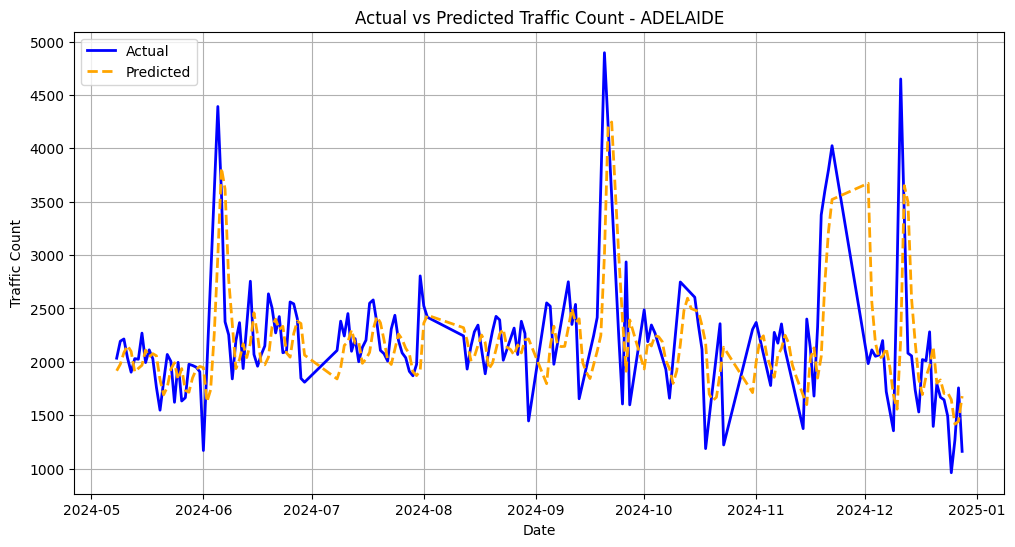

Evaluation Metrics for ADELAIDE: {'MAE': 350.88136017628204, 'RMSE': 506.0905079606785, 'R2': 0.24921564407149965}
Training LSTM model for PARLIAMENT...
Epoch 1/30
49/49 - 4s - 88ms/step - loss: 9460804.0000 - mae: 2948.5251 - val_loss: 14152911.0000 - val_mae: 3666.1233
Epoch 2/30
49/49 - 1s - 17ms/step - loss: 3952086.0000 - mae: 1585.1941 - val_loss: 807677.3750 - val_mae: 650.1210
Epoch 3/30
49/49 - 1s - 18ms/step - loss: 429572.1562 - mae: 478.3441 - val_loss: 653606.8125 - val_mae: 519.1973
Epoch 4/30
49/49 - 1s - 25ms/step - loss: 415465.2500 - mae: 469.4504 - val_loss: 637922.3125 - val_mae: 512.5284
Epoch 5/30
49/49 - 1s - 13ms/step - loss: 399987.6250 - mae: 461.2222 - val_loss: 628805.7500 - val_mae: 509.2073
Epoch 6/30
49/49 - 1s - 13ms/step - loss: 397341.1250 - mae: 452.4437 - val_loss: 626151.6875 - val_mae: 509.3402
Epoch 7/30
49/49 - 0s - 9ms/step - loss: 404663.5625 - mae: 467.5804 - val_loss: 620195.1875 - val_mae: 508.9896
Epoch 8/30
49/49 - 1s - 10ms/step - loss: 4

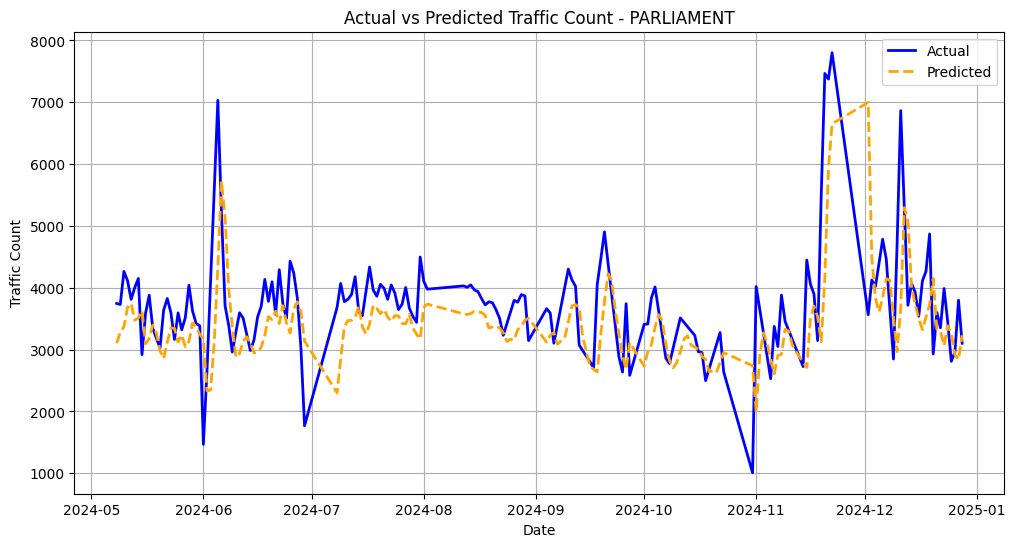

Evaluation Metrics for PARLIAMENT: {'MAE': 558.0200120192308, 'RMSE': 813.5736088245498, 'R2': 0.07946450296670282}
Training LSTM model for Intersection...
Epoch 1/30
48/48 - 5s - 96ms/step - loss: 101755.7656 - mae: 297.8170 - val_loss: 173974.9844 - val_mae: 393.3219
Epoch 2/30
48/48 - 1s - 19ms/step - loss: 42311.0430 - mae: 162.2823 - val_loss: 25327.4551 - val_mae: 112.2084
Epoch 3/30
48/48 - 1s - 13ms/step - loss: 11080.0186 - mae: 72.5334 - val_loss: 18988.6406 - val_mae: 89.5250
Epoch 4/30
48/48 - 0s - 9ms/step - loss: 10932.4854 - mae: 72.9728 - val_loss: 22365.3301 - val_mae: 102.4609
Epoch 5/30
48/48 - 1s - 13ms/step - loss: 10805.1914 - mae: 72.0273 - val_loss: 19095.7344 - val_mae: 90.7324
Epoch 6/30
48/48 - 0s - 9ms/step - loss: 10734.9629 - mae: 71.6722 - val_loss: 16408.2480 - val_mae: 81.0869
Epoch 7/30
48/48 - 1s - 18ms/step - loss: 11117.4580 - mae: 74.5703 - val_loss: 16498.5195 - val_mae: 81.6618
Epoch 8/30
48/48 - 1s - 14ms/step - loss: 11069.0889 - mae: 72.7704 -

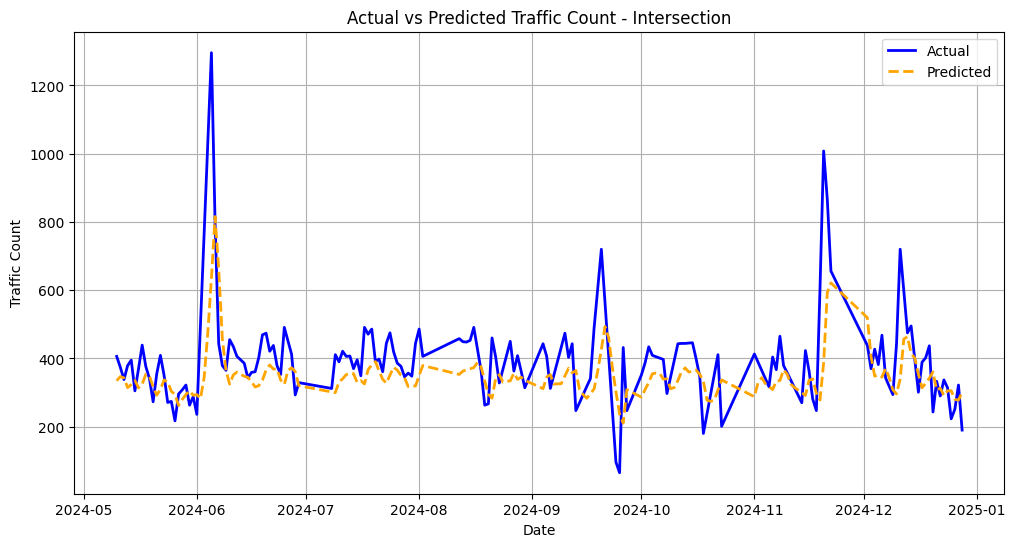

Evaluation Metrics for Intersection: {'MAE': 80.58889190355937, 'RMSE': 124.03839181436493, 'R2': 0.2034676249916766}


In [19]:
## LSTM Implementation

# Importing necessary libraries
from tensorflow.keras.layers import LSTM
# Preparing the data for LSTM
def prepare_lstm_data(X, y):
    # LSTM needs a 3D input: (samples, time steps, features)
    X_reshaped = X.values.reshape(X.shape[0], X.shape[1], 1)
    return X_reshaped, y

# Preprocessing the data for LSTM by splitting it into the 80/20 test split and scaling it
def preprocess_data_for_lstm(X, y):
    # Splitting training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Scaling the features
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshaping the data for LSTM
    X_train_lstm, y_train_lstm = prepare_lstm_data(pd.DataFrame(X_train_scaled), y_train)
    X_test_lstm, y_test_lstm = prepare_lstm_data(pd.DataFrame(X_test_scaled), y_test)

    return X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, scaler

# Building the LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),  # Explicit input layer
        LSTM(50, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dense(1)  # Single output for regression
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train and Evaluate LSTM Model
def train_and_evaluate_lstm_model(X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, input_shape, epochs=30, batch_size=16):
    """
    Trains and evaluates an LSTM model using preprocessed and reshaped data.

    Parameters:
    X_train_lstm : Training features (3D input for LSTM)
    y_train_lstm : Training target
    X_test_lstm : Testing features (3D input for LSTM)
    y_test_lstm : Testing target
    input_shape : Shape of the input data for the LSTM
    epochs : Number of training epochs (default 30)
    batch_size : Batch size for training (default 16)

    Returns:
    Evaluation metrics (MAE, RMSE, R²)
    Trained LSTM model
    """
    # Build the LSTM model
    lstm_model = build_lstm_model(input_shape)

    # Train the LSTM model
    lstm_model.fit(
        X_train_lstm, y_train_lstm,
        validation_data=(X_test_lstm, y_test_lstm),
        epochs=epochs,
        batch_size=batch_size,
        verbose=2
    )

    # Make predictions using the model
    y_pred = lstm_model.predict(X_test_lstm).flatten()

    # Define model evaluation metrics
    lstm_metrics = {
        'MAE': mean_absolute_error(y_test_lstm, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_lstm, y_pred)),
        'R2': r2_score(y_test_lstm, y_pred)
    }

    return lstm_metrics, lstm_model

# Train and evaluate LSTM models for each dataset
lstm_models = {}
lstm_scalers = {}
lstm_results = {}
lstm_scaled_data = {}

for name, (X, y) in prepared_data.items():
    print(f"Training LSTM model for {name}...")

    # Preprocess data
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, scaler = preprocess_data_for_lstm(X, y)

    # Define input shape for LSTM
    input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])

    # Build, train, and evaluate the LSTM model
    metrics, model = train_and_evaluate_lstm_model(
        X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm, input_shape
    )

    # Store results
    lstm_models[name] = model
    lstm_scalers[name] = scaler
    lstm_results[name] = metrics
    lstm_scaled_data[name] = (X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm)

    # Plot actual vs predicted
    y_pred = model.predict(X_test_lstm).flatten()
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_lstm.index, y_test_lstm, label='Actual', color='blue', linewidth=2)
    plt.plot(y_test_lstm.index, y_pred, label='Predicted', linestyle='--', color='orange', linewidth=2)
    plt.title(f'Actual vs Predicted Traffic Count - {name}')
    plt.xlabel('Date')
    plt.ylabel('Traffic Count')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Evaluation Metrics for {name}: {metrics}")

## Comparing the metrics to determine the best model

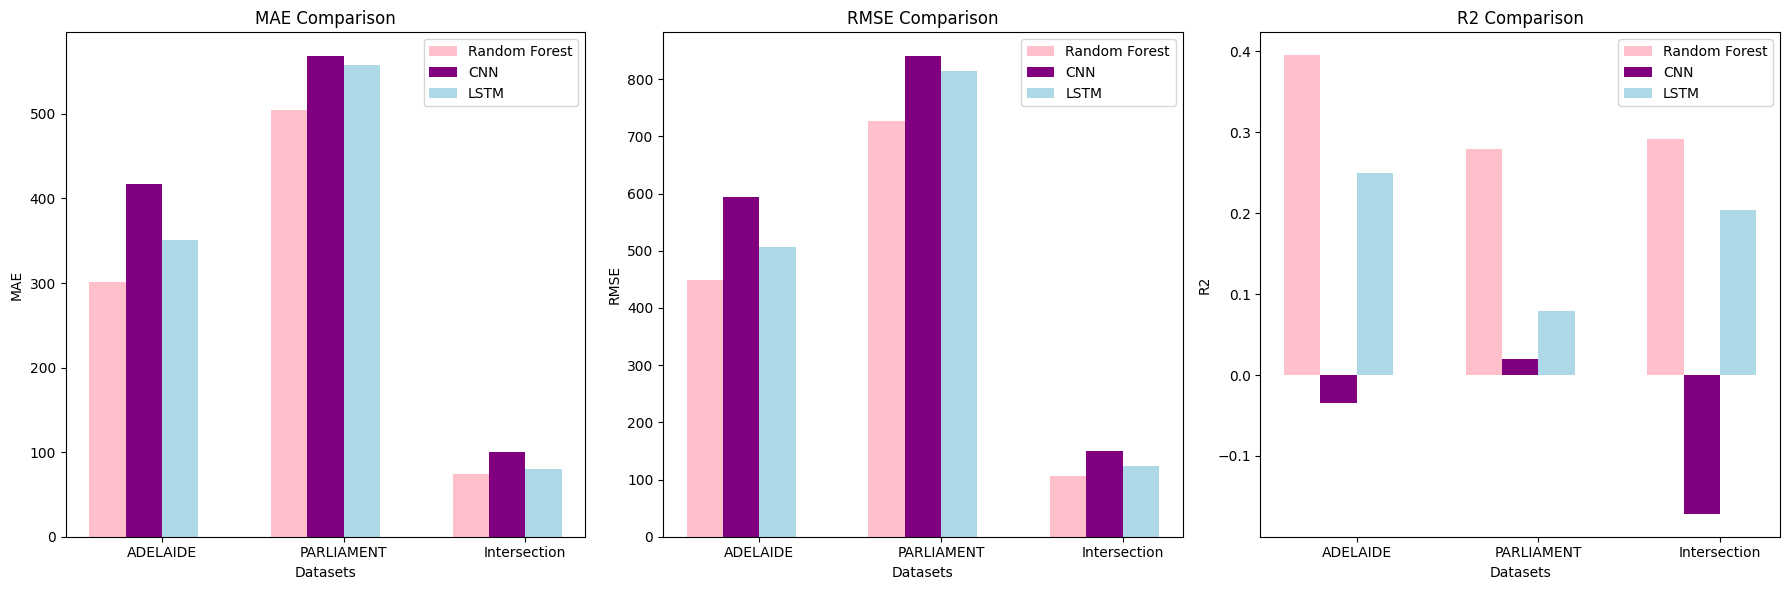


Dataset: ADELAIDE
Random Forest Metrics: {'MAE': 301.59599315068493, 'RMSE': 448.9410676433833, 'R2': 0.395038675909693}
CNN Metrics: {'MAE': 417.0726981921074, 'RMSE': 593.9344183306125, 'R2': -0.03403637692959749}
LSTM Metrics: {'MAE': 350.88136017628204, 'RMSE': 506.0905079606785, 'R2': 0.24921564407149965}

Best Model for Each Metric:
MAE: Random Forest
RMSE: Random Forest
R2: Random Forest

Dataset: PARLIAMENT
Random Forest Metrics: {'MAE': 504.0218493150685, 'RMSE': 726.7026989135372, 'R2': 0.2791077804462301}
CNN Metrics: {'MAE': 568.0472468449519, 'RMSE': 839.7851075280395, 'R2': 0.019193866408515614}
LSTM Metrics: {'MAE': 558.0200120192308, 'RMSE': 813.5736088245498, 'R2': 0.07946450296670282}

Best Model for Each Metric:
MAE: Random Forest
RMSE: Random Forest
R2: Random Forest

Dataset: Intersection
Random Forest Metrics: {'MAE': 74.62631944444443, 'RMSE': 106.73860114785091, 'R2': 0.2915340231183179}
CNN Metrics: {'MAE': 100.48866144816081, 'RMSE': 150.4226077282031, 'R2': 

In [21]:
# List of datasets (keys in the dictionaries)
datasets = list(cnn_results.keys())

# Extract metrics for comparison
metrics_names = ['MAE', 'RMSE', 'R2']

# Prepare data for visualization
all_rf_metrics = []
all_cnn_metrics = []
all_lstm_metrics = []

for dataset in datasets:
    rf_values = [results[dataset][metric] for metric in metrics_names]
    cnn_values = [cnn_results[dataset][metric] for metric in metrics_names]
    lstm_values = [lstm_results[dataset][metric] for metric in metrics_names]
    all_rf_metrics.append(rf_values)
    all_cnn_metrics.append(cnn_values)
    all_lstm_metrics.append(lstm_values)

# Visualize Metrics
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for idx, metric_name in enumerate(metrics_names):
    x = np.arange(len(datasets))  # Dataset indices
    rf_values = [results[dataset][metric_name] for dataset in datasets]
    cnn_values = [cnn_results[dataset][metric_name] for dataset in datasets]
    lstm_values = [lstm_results[dataset][metric_name] for dataset in datasets]

    # Create bar chart
    axs[idx].bar(x - 0.3, rf_values, 0.2, label='Random Forest', color='pink')
    axs[idx].bar(x - 0.1, cnn_values, 0.2, label='CNN', color='purple')
    axs[idx].bar(x + 0.1, lstm_values, 0.2, label='LSTM', color='lightblue')

    axs[idx].set_xlabel('Datasets')
    axs[idx].set_ylabel(metric_name)
    axs[idx].set_title(f'{metric_name} Comparison')
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(datasets)
    axs[idx].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

# Compare metrics for each dataset
for dataset in datasets:
    rf_metrics = results[dataset]
    cnn_metrics = cnn_results[dataset]
    lstm_metrics = lstm_results[dataset]

    print(f"\nDataset: {dataset}")
    print(f"Random Forest Metrics: {rf_metrics}")
    print(f"CNN Metrics: {cnn_metrics}")
    print(f"LSTM Metrics: {lstm_metrics}")

    # Determine which model performs best for each metric
    best_mae = min(rf_metrics['MAE'], cnn_metrics['MAE'], lstm_metrics['MAE'])
    best_rmse = min(rf_metrics['RMSE'], cnn_metrics['RMSE'], lstm_metrics['RMSE'])
    best_r2 = max(rf_metrics['R2'], cnn_metrics['R2'], lstm_metrics['R2'])

    print("\nBest Model for Each Metric:")
    print(f"MAE: {'Random Forest' if best_mae == rf_metrics['MAE'] else 'CNN' if best_mae == cnn_metrics['MAE'] else 'LSTM'}")
    print(f"RMSE: {'Random Forest' if best_rmse == rf_metrics['RMSE'] else 'CNN' if best_rmse == cnn_metrics['RMSE'] else 'LSTM'}")
    print(f"R2: {'Random Forest' if best_r2 == rf_metrics['R2'] else 'CNN' if best_r2 == cnn_metrics['R2'] else 'LSTM'}")